# Lab ML for DS SS23
## Project 3
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [6]:
np.random.seed(7)
n_samples = 100


def load_images(n_samples, path):
    filelist = glob.glob(path)
    if n_samples < len(filelist):
        filelist = np.random.choice(filelist, n_samples)
    return np.array([cv2.imread(fname) for fname in filelist])


apple_healty = load_images(n_samples, "images/Apple___healthy/*.JPG") / 255
apple_black_rot = load_images(n_samples, "images/Apple___Black_rot/*.JPG") / 255

print(apple_healty.shape)
print(apple_black_rot.shape)

(100, 256, 256, 3)
(100, 256, 256, 3)


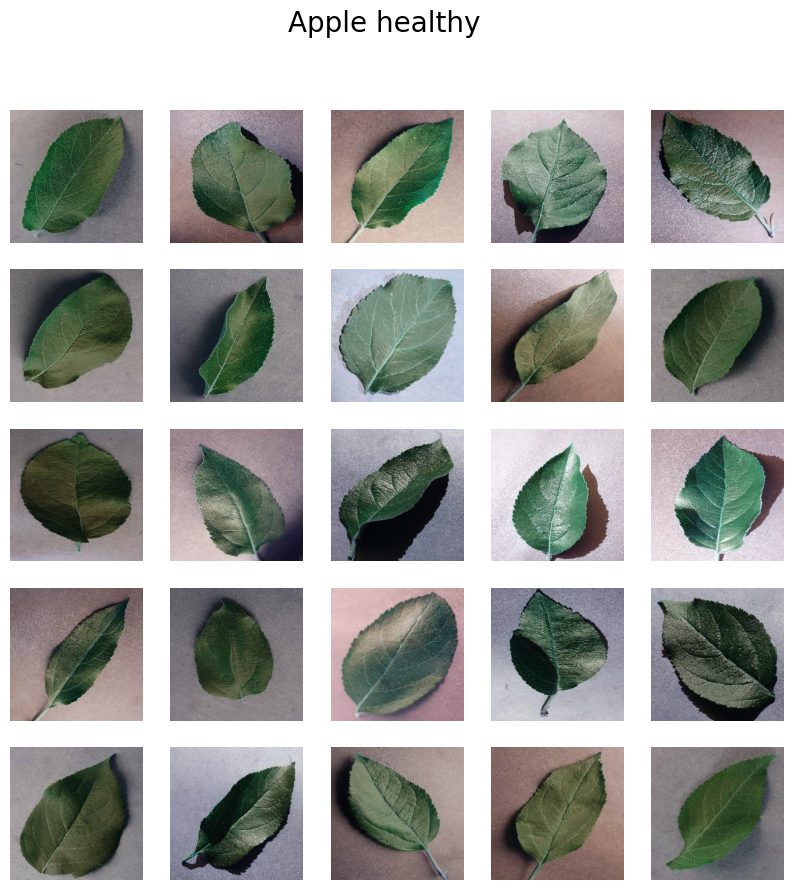

In [7]:
# plot some images in a 5 x 5 grid
def plot_images(images, title):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(title, fontsize=20)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

plot_images(apple_healty, "Apple healthy")

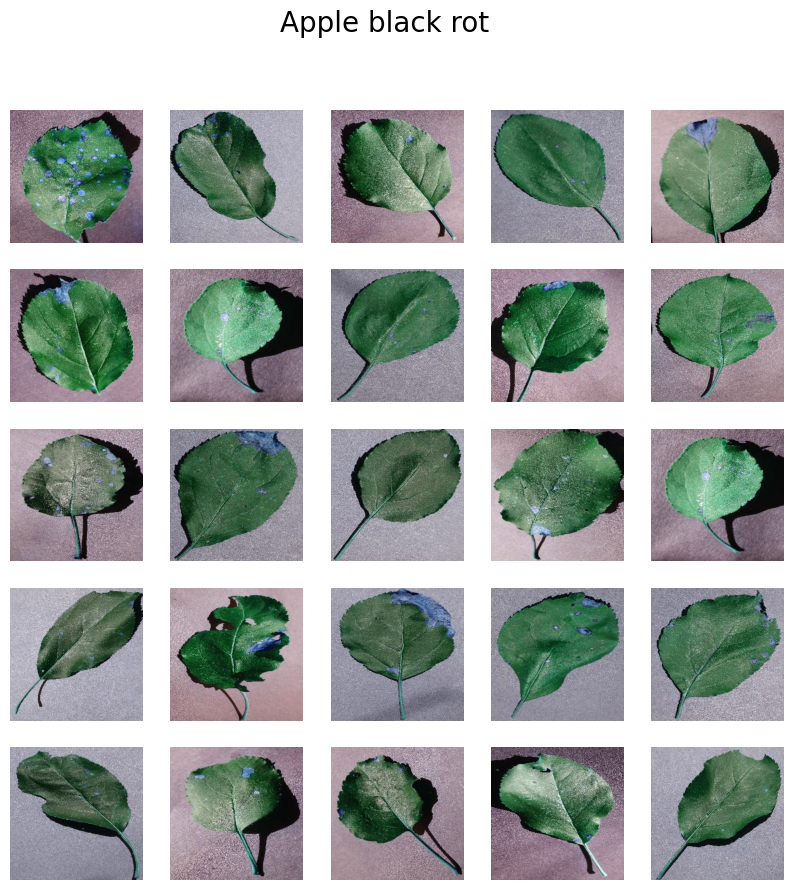

In [8]:
plot_images(apple_black_rot, "Apple black rot")

# TRY VGG16 USING KERAS

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

# create the training and test sets
# use 0 for healthy and 1 for black rot

X_train, X_test, y_train, y_test = train_test_split(
    np.concatenate((apple_healty, apple_black_rot)),
    np.concatenate((np.zeros(apple_healty.shape[0]), np.ones(apple_black_rot.shape[0]))).astype(int),
    test_size=0.2,
    random_state=7,
)

# # Preprocessing input using VGG16 preprocessing
# X_train = preprocess_input(X_train)
# X_test = preprocess_input(X_test)

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

# Loading VGG16 model
vgg16_base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
# Disable training for base model
vgg16_base_model.trainable = False 

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-06-23 20:32:19.237675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-23 20:32:19.237990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
from tensorflow.keras import layers, models

# Add custom head to vgg16 base model
model = models.Sequential([
    vgg16_base_model,
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
model.fit(X_train, y_train, epochs=1, validation_split=0.2, batch_size=16, callbacks=[es])


2023-06-23 20:32:20.343973: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-23 20:32:21.585034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.6641

2023-06-23 20:32:27.659247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 8s 691ms/step - loss: 0.7574 - accuracy: 0.6641 - val_loss: 0.1639 - val_accuracy: 1.0000


In [13]:
# Evaluate the model on the test data
results = model.evaluate(X_test, y_test)

2023-06-23 20:32:29.091715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 233ms/step - loss: 0.1721 - accuracy: 1.0000


2023-06-23 20:32:30.877452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 892ms/step

Confusion Matrix


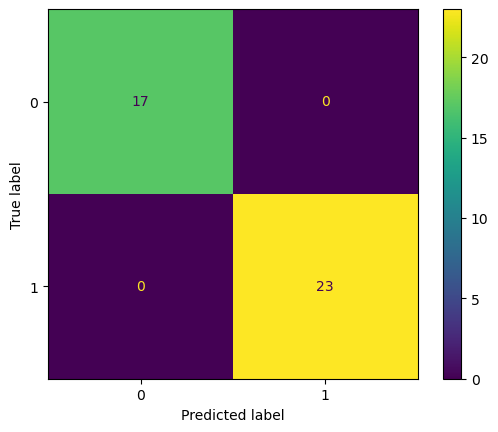


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        23

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



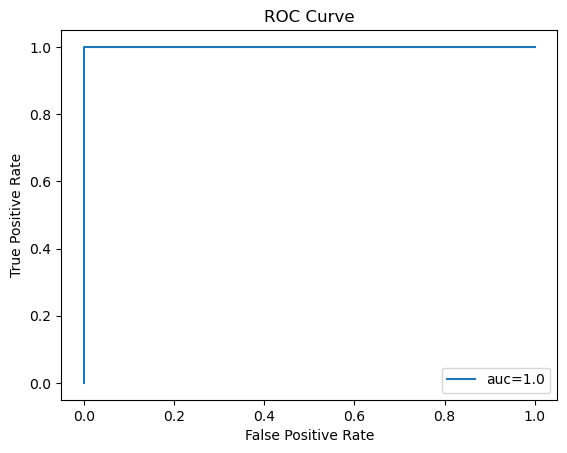

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

# plot roc curve
y_pred = model.predict(X_test)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

print("\nConfusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_classes), display_labels=[0, 1])
disp.plot()
plt.show()

print("\nClassification Report")
print(classification_report(y_test, y_pred_classes))

# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="auc=" + str(roc_auc))
plt.legend(loc=4)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


# 3 Predicting Classes from Image

In [15]:

# how to calculate mean vector with 8 x 8 x 512 shape?

features = vgg16_base_model(X_train)
# flatten?
features = layers.Flatten()(features)

In [16]:
# flatten but keep first dimension
mu1 = 1 / np.sum(y_train == 1) * np.sum(features[y_train == 1], axis=0)
mu2 =  1 / np.sum(y_train == 0) * np.sum(features[(y_train == 0)], axis=0)
w = (mu2 - mu1) / np.linalg.norm(mu2 - mu1)

In [17]:
test = vgg16_base_model(X_test)
test = layers.Flatten()(test)


In [18]:
np.dot(test, w)

array([95.11527 , 92.62299 , 92.986046, 95.18428 , 95.60776 , 96.27032 ,
       93.819244, 91.9965  , 95.329155, 96.341774, 96.89583 , 93.63152 ,
       97.85508 , 95.070274, 96.11496 , 95.75222 , 92.95851 , 92.440765,
       97.17561 , 97.15209 , 95.1229  , 94.555435, 92.32747 , 95.19023 ,
       97.01472 , 94.93012 , 95.21041 , 96.31963 , 97.89261 , 95.13669 ,
       92.67288 , 96.05369 , 96.65869 , 98.35639 , 95.698845, 93.786964,
       96.45198 , 94.07474 , 94.883064, 95.16125 ], dtype=float32)

In [19]:
# import torchvision.models as models
# import torch

# model = models.vgg16(pretrained=True)
# data = torch.randn(1, 3, 256, 256)
# model.features(data).shape

# # pytorch also results in 512 x 8 x 8